<a href="https://colab.research.google.com/github/sdgroeve/Machine_Learning_course_UGent_D012554_2025/blob/main/notebooks/SHAP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting Biomedical Models with SHAP (Heart Disease Classification)

This notebook demonstrates how to use the SHAP (SHapley Additive exPlanations) framework to interpret the predictions of a machine learning model trained on the UCI Heart Disease dataset (Cleveland subset). We will predict the **presence or absence of heart disease** based on clinical features using a Gradient Boosting Classifier and then use SHAP to understand which factors drive the model's predictions, both globally and for individual patients. SHAP provides a principled way to assign importance scores to features, enhancing model transparency.

## Learning Objectives

*   Understand the intuition behind Shapley values and the SHAP framework
*   Generate global and local explanations for a tree-based classifier trained on biomedical data
*   Load data from a URL, handle missing values, and prepare it for modeling
*   Recognize common pitfalls when interpreting SHAP in health contexts

## Environment & Data Sources

*   **Python:** 3.x
*   **Libraries:** `shap` (0.45.0 specified), `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn` (optional, for aesthetics), `joblib` (for saving)
*   **Dataset:** We will use the **UCI Heart Disease dataset (Processed Cleveland subset)**.
    *   *Source:* [https://archive.ics.uci.edu/dataset/45/heart+disease](https://archive.ics.uci.edu/dataset/45/heart+disease)
    *   *Direct Data URL:* `https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data`
    *   *Citation:* Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1988). Heart Disease Dataset. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X

In [1]:
# NOTE: If running locally or in an environment where packages aren't pre-installed,
# you might need to uncomment and run the line below first.
# !pip install shap==0.45.0 scikit-learn pandas matplotlib seaborn joblib -q

# Import necessary libraries
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pathlib
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier

# Set plotting style and ensure plots appear inline
sns.set_style("whitegrid")
%matplotlib inline

# Print library versions
print(f"SHAP version: {shap.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Joblib version: {joblib.__version__}")

SHAP version: 0.47.1
Pandas version: 2.2.2
Numpy version: 2.0.2
Scikit-learn version: 1.6.1
Joblib version: 1.4.2


## 1. Data Loading & Initial Glance

We load the UCI Heart Disease (Cleveland) dataset directly from the UCI repository URL using pandas.

The dataset documentation provides the following column names (in order):

1.  `age`: Age in years
2.  `sex`: Sex (1 = male; 0 = female)
3.  `cp`: Chest pain type (1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic)
4.  `trestbps`: Resting blood pressure (mm Hg)
5.  `chol`: Serum cholesterol (mg/dl)
6.  `fbs`: Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7.  `restecg`: Resting electrocardiographic results (0: normal, 1: ST-T abnormality, 2: hypertrophy)
8.  `thalach`: Maximum heart rate achieved
9.  `exang`: Exercise induced angina (1 = yes; 0 = no)
10. `oldpeak`: ST depression induced by exercise relative to rest
11. `slope`: The slope of the peak exercise ST segment (1: upsloping, 2: flat, 3: downsloping)
12. `ca`: Number of major vessels (0-3) colored by fluoroscopy
13. `thal`: Thalassemia (3 = normal; 6 = fixed defect; 7 = reversible defect)
14. `num`: Diagnosis of heart disease (angiographic disease status) - **This is our original target variable.**
    *   Value 0: < 50% diameter narrowing (No disease)
    *   Value 1-4: > 50% diameter narrowing (Presence of disease)

**Target Label Processing:** We will convert the `num` column into a binary target: **0 = No disease**, **1 = Disease present**.

*Missing Values Note:* This dataset uses '?' to denote missing values. We will load these as NaNs and handle them during preprocessing.

In [2]:
# Define URL and column names for UCI Heart Disease (Cleveland dataset)
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
# Column names based on UCI dataset description documentation
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
                'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

# Load data using pandas
try:
    data = pd.read_csv(url, header=None, names=column_names, na_values='?')
    print(f"Data loaded successfully from UCI URL. Shape: {data.shape}")
    data_loaded = True
except Exception as e:
    print(f"Error loading data from URL: {e}")
    print("Please check the URL or your internet connection. Cannot proceed without data.")
    data_loaded = False
    # Assign empty DataFrame to prevent downstream errors in this cell
    data = pd.DataFrame(columns=column_names)

if data_loaded:
    # Display basic information
    print("\nFirst 5 rows of raw data:")
    print(data.head())

    print("\nData types and missing values in raw data:")
    print(data.info())

    print("\nMissing value counts per column:")
    print(data.isnull().sum())

    # Check original target variable distribution
    print("\nOriginal target ('num') distribution:")
    print(data['num'].value_counts())
else:
    print("\nSkipping data inspection due to loading failure.")

Data loaded successfully from UCI URL. Shape: (303, 14)

First 5 rows of raw data:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  num  
0    3.0  0.0   6.0    0  
1    2.0  3.0   3.0    2  
2    2.0  2.0   7.0    1  
3    3.0  0.0   3.0    0  
4    1.0  0.0   3.0    0  

Data types and missing values in raw data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-nul

## 2. Biomedical-Driven Pre-processing

1.  **Target Variable Conversion:** Convert the `num` column (0-4) into a binary target `target` (0 for no disease, 1 for presence of disease).
2.  **Feature/Target Separation:** Separate the dataset into features (X) and the new binary target (y).
3.  **Train/Validation Split:** Split the data into training and validation sets. It's crucial to do this *before* imputation to prevent data leakage from the validation set into the training set during the imputer fitting stage. We use `stratify=y` to maintain the proportion of classes in both splits, which is important for classification tasks, especially with imbalanced datasets.
4.  **Missing Value Imputation:** Handle the missing values (identified as NaNs). We will use `SimpleImputer` with the `median` strategy, which is generally robust to outliers common in clinical data. The imputer is **fitted only on the training data** and then used to **transform both the training and validation data**.

In [3]:
if data_loaded:
    # 1. Convert target variable to binary
    data['target'] = (data['num'] > 0).astype(int)
    data = data.drop('num', axis=1) # Drop the original target column

    # 2. Separate features (X) and target (y)
    X = data.drop('target', axis=1)
    y = data['target']

    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print("\nBinary target distribution:")
    print(y.value_counts(normalize=True))

    # 3. Train/Validation Split (before imputation)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    print(f"\nTraining set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")

    # 4. Missing Value Imputation (Fit on train, transform train & val)
    print("\nMissing values in X_train BEFORE imputation:")
    print(X_train.isnull().sum().loc[lambda x: x > 0]) # Show only columns with missing values

    # Identify columns with missing values in the original data to impute
    cols_with_missing = data.columns[data.isnull().any()].tolist()
    if 'target' in cols_with_missing: cols_with_missing.remove('target') # Ensure target isn't imputed
    print(f"Columns to impute (based on original data): {cols_with_missing}")

    imputer = SimpleImputer(strategy='median')

    # Fit imputer ONLY on training data features
    imputer.fit(X_train[cols_with_missing])

    # Transform training and validation data
    # IMPORTANT: Keep as DataFrames to retain column names for SHAP
    X_train_imputed_cols = imputer.transform(X_train[cols_with_missing])
    X_val_imputed_cols = imputer.transform(X_val[cols_with_missing])

    # Create new DataFrames with imputed values
    # Use .copy() to avoid SettingWithCopyWarning
    X_train = X_train.copy()
    X_val = X_val.copy()

    X_train[cols_with_missing] = X_train_imputed_cols
    X_val[cols_with_missing] = X_val_imputed_cols

    print("\nMissing values in X_train AFTER imputation:")
    print(X_train.isnull().sum().sum()) # Should be 0
    print("Missing values in X_val AFTER imputation:")
    print(X_val.isnull().sum().sum())   # Should be 0

    print("\nFirst 5 rows of processed X_train:")
    print(X_train.head())

    preprocessing_done = True
else:
    print("Skipping preprocessing due to data loading failure.")
    preprocessing_done = False

Features shape: (303, 13)
Target shape: (303,)

Binary target distribution:
target
0    0.541254
1    0.458746
Name: proportion, dtype: float64

Training set shape: X=(212, 13), y=(212,)
Validation set shape: X=(91, 13), y=(91,)

Missing values in X_train BEFORE imputation:
thal    1
dtype: int64
Columns to impute (based on original data): ['ca', 'thal']

Missing values in X_train AFTER imputation:
0
Missing values in X_val AFTER imputation:
0

First 5 rows of processed X_train:
      age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
230  52.0  0.0  3.0     136.0  196.0  0.0      2.0    169.0    0.0      0.1   
43   59.0  1.0  3.0     150.0  212.0  1.0      0.0    157.0    0.0      1.6   
283  35.0  1.0  2.0     122.0  192.0  0.0      0.0    174.0    0.0      0.0   
206  58.0  1.0  4.0     128.0  259.0  0.0      2.0    130.0    1.0      3.0   
42   71.0  0.0  2.0     160.0  302.0  0.0      0.0    162.0    0.0      0.4   

     slope   ca  thal  
230    2.0  0.0  

## 3. Train a Predictive Model

We will train a **Gradient Boosting Classifier (GBC)**.
*   **Why GBC?** It's a powerful tree-based ensemble model often achieving good performance on tabular data like this. SHAP has a highly optimized and exact algorithm (`TreeSHAP`) specifically for tree-based models, making interpretation efficient and accurate.

*   **Performance Evaluation:** Before interpreting, we must confirm the model has reasonable predictive power. We'll evaluate using **Area Under the Receiver Operating Characteristic Curve (AUROC)** and **Area Under the Precision-Recall Curve (PR-AUC)** on the validation set. PR-AUC is particularly relevant when classes might be imbalanced. We'll also look at a classification report for precision, recall, and F1-score.

In [4]:
if preprocessing_done:
    # Initialize and train the Gradient Boosting Classifier
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train) # Train on imputed training data

    # Predict probabilities and classes on the validation set
    y_pred_proba = model.predict_proba(X_val)[:, 1] # Probability of the positive class (disease)
    y_pred_class = model.predict(X_val) # Predicted class labels

    # Calculate performance metrics
    auroc = roc_auc_score(y_val, y_pred_proba)
    pr_auc = average_precision_score(y_val, y_pred_proba)

    print(f"Model Performance on Validation Set:")
    print(f"AUROC: {auroc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_val, y_pred_class, target_names=['No Disease (0)', 'Disease (1)']))

    # Check if performance is reasonable
    if auroc < 0.7:
        print("\nWarning: Model AUROC is relatively low. Interpretations might be less reliable.")

    model_trained = True
else:
    print("Skipping model training due to preprocessing failure.")
    model_trained = False

Model Performance on Validation Set:
AUROC: 0.9052
PR-AUC: 0.8999

Classification Report:
                precision    recall  f1-score   support

No Disease (0)       0.83      0.82      0.82        49
   Disease (1)       0.79      0.81      0.80        42

      accuracy                           0.81        91
     macro avg       0.81      0.81      0.81        91
  weighted avg       0.81      0.81      0.81        91



## 4. A 5-Minute SHAP Theory Primer

*   **Origin:** Shapley values come from cooperative game theory, designed to fairly distribute the "payout" (model prediction) among "players" (features).
*   **SHAP:** SHAP (SHapley Additive exPlanations) adapts this concept for machine learning models. It guarantees certain desirable properties for feature attributions:
    *   **Local Accuracy:** The sum of SHAP values for a single prediction equals the difference between the model's output for that instance and the baseline (average) prediction. `sum(shap_values[i]) ≈ model.predict(xi) - baseline` (often in log-odds space for classifiers).
    *   **Missingness:** Features that are truly missing should ideally have a SHAP value of zero (though imputation complicates this; SHAP operates on the *post-imputation* data).
    *   **Consistency:** If a model changes so that a feature's marginal contribution increases or stays the same (regardless of other features), its SHAP value should not decrease.
*   **Intuition:** A feature's SHAP value represents its average marginal contribution to the prediction across all possible combinations (coalitions) of other features. It quantifies how much this feature's value pushed the prediction away from the average prediction.
*   **Explainer Types:** SHAP provides different explainers optimized for various model types:
    *   **TreeSHAP:** Fast and exact for tree-based models (like the GBC we are using).
    *   **KernelSHAP:** Model-agnostic, works for any model but can be slower.
    *   **DeepSHAP:** Optimized for deep learning models.
    *   *Others:* GradientExplainer, LinearExplainer, etc.

## 5. Computing SHAP Values

Since we trained a `GradientBoostingClassifier`, we use `shap.TreeExplainer`. We compute the SHAP values for our **imputed validation set (`X_val`)**. This calculates the contribution of each feature to the prediction for every patient in the validation set. The result is a NumPy array (or list of arrays for multi-class) where rows correspond to patients and columns correspond to features.

For binary classification with GBC, `explainer.shap_values()` typically returns SHAP values corresponding to the **positive class (class 1, presence of heart disease)**. The `explainer()` method (newer API) returns a richer `Explanation` object which is often more convenient for plotting.

In [5]:
if model_trained:
    # Initialize the SHAP explainer for our tree-based model
    explainer = shap.TreeExplainer(model)

    # Compute SHAP values for the validation set (using the imputed data)
    # For GBC binary classification, this gives SHAP values for the positive class (1)
    shap_values_array = explainer.shap_values(X_val)

    # Compute SHAP values using the Explanation object interface (recommended)
    shap_values_exp = explainer(X_val)

    # Check the shape of the SHAP values array
    # Should be (n_samples_val, n_features)
    print("SHAP values array shape:", shap_values_array.shape)
    # Check the type and structure of the Explanation object
    print("SHAP Explanation object type:", type(shap_values_exp))
    print("SHAP Explanation object shape:", shap_values_exp.shape)

    shap_computed = True
else:
    print("Skipping SHAP computation as model was not trained.")
    shap_computed = False

SHAP values array shape: (91, 13)
SHAP Explanation object type: <class 'shap._explanation.Explanation'>
SHAP Explanation object shape: (91, 13)


## 6. Global Feature Importance

We can understand global feature importance by averaging the *absolute* SHAP values across all samples (`mean(|SHAP value|)`). This indicates the average magnitude of impact each feature has on the model's predictions (in log-odds space for this classifier).

*   **Comparison to Model Importance:** Standard GBC `feature_importances_` (Gini-based) can differ from SHAP importance. SHAP considers the magnitude and direction of impact on the model's *output*, providing a potentially more faithful explanation of predictive contribution.
*   **Biomedical Angle:** Do the top features identified by SHAP align with known clinical risk factors for heart disease? We might expect features like `ca` (number of vessels), `thal` (thalassemia type), `cp` (chest pain type), `thalach` (max heart rate), and `oldpeak` (ST depression) to be important. Are there any surprises?

We visualize this using a **bar plot** (for mean absolute SHAP values) and a **beeswarm plot** (shows distribution and direction of impact).

Global Feature Importance (Bar Plot):


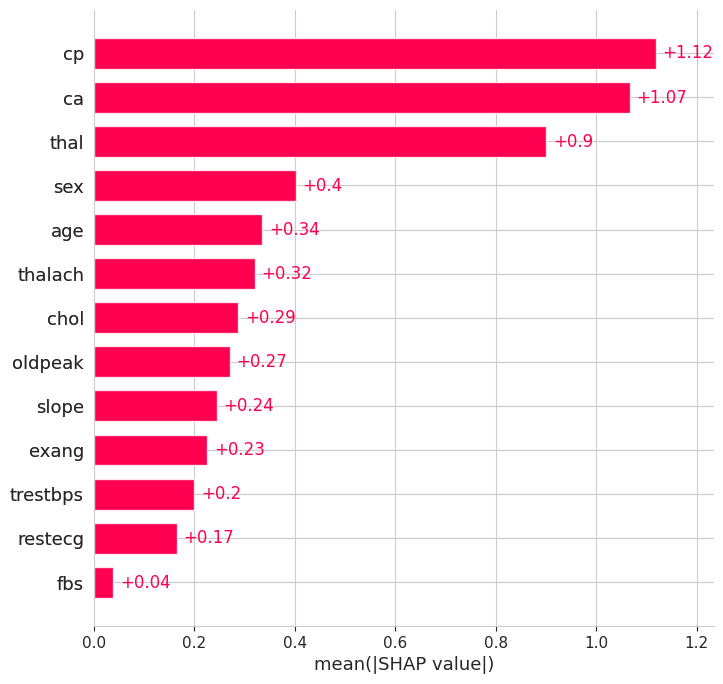


Global Feature Importance (Beeswarm Plot):


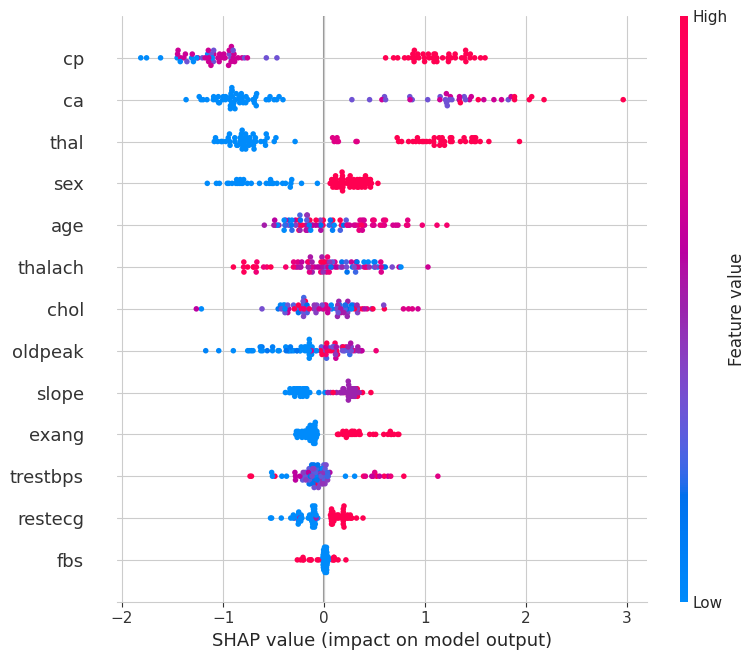

In [6]:
if shap_computed:
    # Use the Explanation object for plotting (simpler syntax)

    # Bar plot: Shows mean absolute SHAP value per feature
    print("Global Feature Importance (Bar Plot):")
    plt.figure()
    shap.plots.bar(shap_values_exp, max_display=15)
    # plt.show() might be needed depending on environment

    # Beeswarm plot: Shows SHAP value distribution for each feature
    # Color represents feature value (red=high, blue=low)
    print("\nGlobal Feature Importance (Beeswarm Plot):")
    plt.figure()
    shap.summary_plot(shap_values_exp, X_val, max_display=15)
    # plt.show() might be needed depending on environment

else:
    print("Skipping global importance plots as SHAP values were not computed.")

**Interpretation of Beeswarm:**
*   Each point is a SHAP value for a specific patient and feature.
*   **X-axis:** SHAP value (impact on model output log-odds). Positive values push the prediction towards heart disease (class 1); negative values push towards no disease (class 0).
*   **Y-axis:** Features, ordered by global importance (mean |SHAP value|).
*   **Color:** The actual value of the feature for that patient (High values = Red, Low values = Blue).

*Example:* For `ca` (number of major vessels), we expect high values (red points) to have positive SHAP values, increasing the predicted risk of heart disease. For `thalach` (max heart rate), we might expect high values (red) to have negative SHAP values (protective effect).

## 7. Dependence & Interaction Plots

SHAP dependence plots show how the model's output (via SHAP value) for a single feature changes as the feature's value varies across all patients. We can color these points by the value of another feature to visualize potential **interaction effects**.

*   **Example:** How does the impact of `thalach` (max heart rate) change with patient `age`? Does the impact of `cp` (chest pain type) differ based on `sex`?
*   **Warning:** These plots reveal correlations and interactions *learned by the model*. They do **not** prove causation. Be cautious interpreting trends in sparse regions of the plot where there's little data.

SHAP Dependence Plot for 'ca', colored by 'age':


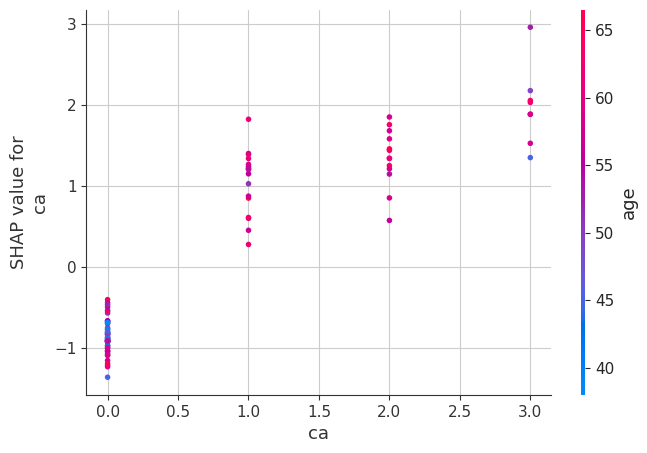


SHAP Dependence Plot for 'thalach', colored by 'age':


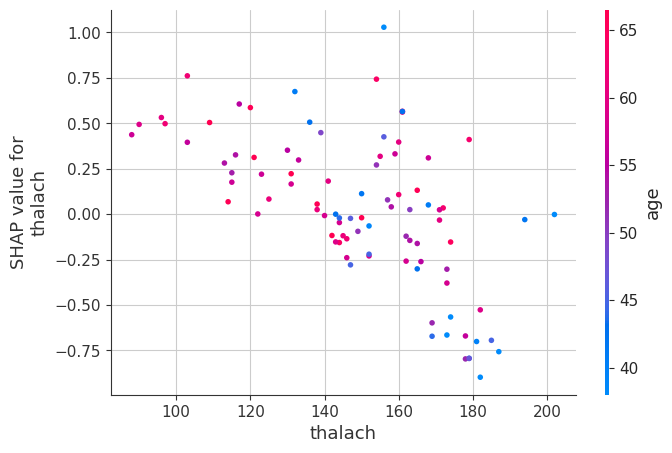


SHAP Dependence Plot for 'cp', colored by 'sex':


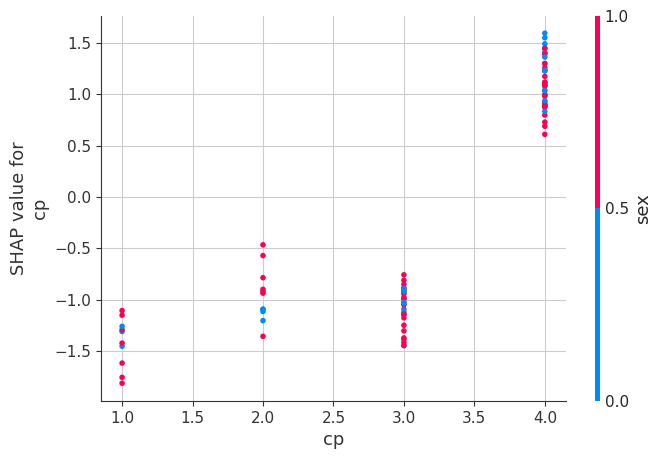

In [7]:
if shap_computed:
    # Select a few features for dependence plots
    feature_1 = 'ca' # Number of major vessels
    interaction_feature_1 = 'age'

    feature_2 = 'thalach' # Max heart rate
    interaction_feature_2 = 'age'

    feature_3 = 'cp' # Chest pain type
    interaction_feature_3 = 'sex' # Interaction with sex (0=female, 1=male)

    print(f"SHAP Dependence Plot for '{feature_1}', colored by '{interaction_feature_1}':")
    shap.dependence_plot(feature_1, shap_values_array, X_val, interaction_index=interaction_feature_1)

    print(f"\nSHAP Dependence Plot for '{feature_2}', colored by '{interaction_feature_2}':")
    shap.dependence_plot(feature_2, shap_values_array, X_val, interaction_index=interaction_feature_2)

    print(f"\nSHAP Dependence Plot for '{feature_3}', colored by '{interaction_feature_3}':")
    # Use feature name directly with Explanation object
    shap.dependence_plot(feature_3, shap_values_exp.values, X_val, interaction_index=interaction_feature_3)

else:
    print("Skipping dependence plots as SHAP values were not computed.")

**Interpretation of Dependence Plot:**
*   **Y-axis:** SHAP value for the feature on the X-axis.
*   **X-axis:** Value of the feature being plotted.
*   **Color:** Value of the `interaction_index` feature.

Look for overall trends (e.g., does the SHAP value for `ca` increase as `ca` increases?) and vertical patterns/separation caused by the interaction feature (e.g., are older patients (red dots) consistently higher or lower than younger patients (blue dots) for a given `ca` value?).

## 8. Local (Per-Patient) Explanations

SHAP allows us to explain the prediction for a single, specific patient. **Waterfall plots** and **force plots** visualize how each feature's value for that patient contributes to moving the prediction away from the baseline (average prediction across the training set).

*   **Sign Convention:**
    *   **Positive SHAP values (red):** Features pushing the prediction towards 1 (presence of heart disease).
    *   **Negative SHAP values (blue):** Features pushing the prediction towards 0 (absence of heart disease).
*   **Baseline:** The `explainer.expected_value` represents the average model prediction output (in log-odds space for GBC) over the training data.
*   **Clinical Storytelling:** These plots help explain *why* a specific patient received their risk score. Start with the baseline risk, then add the impact of each major contributing feature (e.g., "The baseline risk was X. However, having 3 blocked vessels (`ca=3`) significantly increased the risk, while having a high max heart rate (`thalach=180`) slightly decreased it, leading to the final prediction Y.").

--- Explaining prediction for patient index: 15 ---
Actual label: 0
Predicted probability (disease): 0.0088
Patient's feature values:
age          39.0
sex           0.0
cp            3.0
trestbps    138.0
chol        220.0
fbs           0.0
restecg       0.0
thalach     152.0
exang         0.0
oldpeak       0.0
slope         2.0
ca            0.0
thal          3.0
Name: 277, dtype: float64



Waterfall plot for patient index 15:


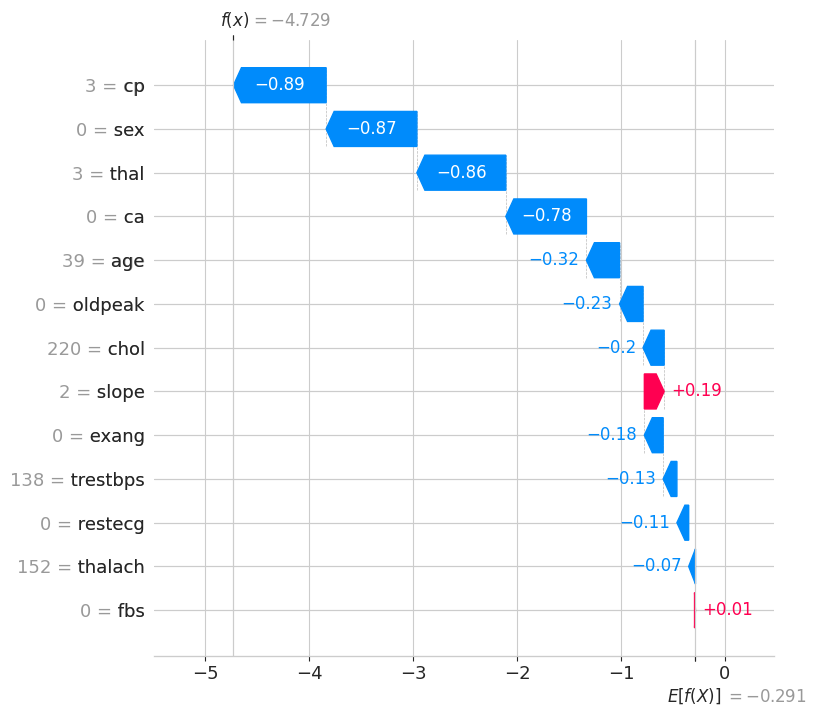


Force plot for patient index 15:


In [8]:
if shap_computed:
    # Choose an example patient index from the validation set
    idx = 15 # You can change this index (0 to len(X_val)-1)
    print(f"--- Explaining prediction for patient index: {idx} ---")
    print(f"Actual label: {y_val.iloc[idx]}")
    print(f"Predicted probability (disease): {y_pred_proba[idx]:.4f}")
    print(f"Patient's feature values:\n{X_val.iloc[idx]}")

    # Initialize JavaScript visualization in the notebook for force plots
    shap.initjs()

    # Explain the prediction using a waterfall plot
    print(f"\nWaterfall plot for patient index {idx}:")
    # We can directly use the slice of the Explanation object
    plt.figure()
    shap.plots.waterfall(shap_values_exp[idx], max_display=15)
    #plt.show() # May be needed

    # Explain the prediction using a force plot
    print(f"\nForce plot for patient index {idx}:")
    # Use the Explanation object slice directly
    shap.force_plot(explainer.expected_value,
                    shap_values_array[idx,:],
                    X_val.iloc[idx,:],
                    matplotlib=False) # Set matplotlib=True for static image if JS fails
    # OR using the Explanation object directly (often preferred)
    # shap.plots.force(shap_values_exp[idx])

    # Force plot for multiple samples (good for overview, can be slow)
    # print("\nForce plot for the first 20 validation samples:")
    # shap.plots.force(shap_values_exp[:20])
else:
    print("Skipping local explanation plots as SHAP values were not computed.")

**Interpretation of Local Plots:**
*   **Waterfall:** Starts at the bottom with the base value (`E[f(X)]`). Each arrow shows a feature's contribution (SHAP value), adding (red) or subtracting (blue) from the cumulative log-odds. The final value at the top (`f(x)`) is the model's raw output for this patient before the logistic transformation.
*   **Force Plot:** Shows the same information horizontally. Red features push the prediction higher (right, towards disease), blue features push it lower (left, towards no disease). The width of the bar indicates the magnitude of the feature's impact.

## 9. Model-Reliability Checks

While SHAP provides detailed explanations, it's crucial to perform sanity checks and understand its limitations, especially in high-stakes domains like healthcare.

*   **Compare to Domain Knowledge:** Does the global SHAP importance ranking align with established clinical risk factors for heart disease? Are the directions of effects (e.g., high `ca` increases risk, high `thalach` decreases risk) clinically plausible? Significant deviations warrant investigation.
*   **Compare to Simpler Methods:** Does the SHAP ranking roughly align with univariate analyses (e.g., feature correlations with the target, coefficients from a simple logistic regression)? While SHAP captures complex interactions, major discrepancies might signal issues.
*   **Limitations:**
    *   **Correlated Features:** SHAP may distribute importance among highly correlated features (e.g., if two lab values tend to rise together). This doesn't mean the features aren't important, but their individual SHAP values might be diluted.
    *   **Association vs. Causation:** SHAP explains *model predictions based on associations* in the data. It **cannot** determine causality. A high SHAP value for a feature doesn't mean *changing* that feature will change the outcome in reality.
    *   **Data Quality:** SHAP explains the model's behavior on the *given* data. If the data has errors, biases, or missingness was handled poorly, the explanations will reflect the model's potentially flawed learning.
    *   **Model Dependence:** Explanations are specific to the trained model. A different model (e.g., a neural network) trained on the same data might produce different SHAP values.

## 10. Fairness & Ethics Sidebar (Optional but Recommended)

SHAP can be a tool for auditing potential fairness issues, but requires careful interpretation.

*   **Auditing Protected Attributes:** Examine the SHAP values for protected attributes like `age` and `sex`.
    *   Are they among the top drivers of predictions? (Sometimes necessary, e.g., age is a known risk factor).
    *   More importantly, are there significant differences in SHAP value distributions *for other features* across different demographic groups (e.g., does the model rely on `chol` differently for males vs. females)? This can be checked using stratified beeswarm or dependence plots.
*   **When NOT to Show Explanations:**
    *   **Privacy:** Detailed local explanations reveal how a prediction relies on sensitive patient data. Sharing these requires careful consideration of privacy regulations (like HIPAA).
    *   **Cognitive Overload / Misinterpretation:** Complex SHAP plots might overwhelm or mislead users (clinicians, patients) if not presented clearly, with context and caveats. Simpler explanations might be better in some clinical contexts.
    *   **Gaming the System:** If explanations are too transparent, it might enable manipulating inputs to achieve a desired classification.

Ethical use involves balancing transparency benefits with potential risks.

## 11. Saving & Sharing Explanations

Computing SHAP values can be time-consuming for large datasets or complex models. It's often useful to save the computed values and the explainer's base value for later analysis or sharing.

*   **Saving:** We can save the SHAP values array (`shap_values_array`) and the `explainer.expected_value` using `joblib` or similar serialization libraries.
*   **Sharing Plots:** Individual plots (waterfall, dependence) can be saved as image files (PNG, SVG). Force plots can be saved as interactive HTML files using `shap.save_html`.

In [9]:
if shap_computed:
    # Create an output directory if it doesn't exist
    output_dir = pathlib.Path("outputs_heart_disease")
    output_dir.mkdir(exist_ok=True)

    # Save the SHAP values array (NumPy array)
    shap_values_filename = output_dir / "shap_values_heart_disease.pkl"
    joblib.dump(shap_values_array, shap_values_filename)
    print(f"SHAP values array saved to: {shap_values_filename}")

    # Save the explainer's expected value
    expected_value_filename = output_dir / "explainer_expected_value.pkl"
    joblib.dump(explainer.expected_value, expected_value_filename)
    print(f"Explainer expected value saved to: {expected_value_filename}")

    # Save the validation data used for explanations (important context)
    X_val_filename = output_dir / "X_val_imputed.pkl"
    X_val.to_pickle(X_val_filename)
    print(f"Imputed validation features (X_val) saved to: {X_val_filename}")

    # --- Example: Save specific plots ---
    idx_to_save = idx # Use the index from the local explanation section

    # Save waterfall plot as image
    waterfall_img_filename = output_dir / f"waterfall_patient_{idx_to_save}.png"
    plt.figure() # Create a new figure context
    shap.plots.waterfall(shap_values_exp[idx_to_save], max_display=15, show=False)
    plt.savefig(waterfall_img_filename, bbox_inches='tight')
    plt.close() # Close the figure
    print(f"Waterfall plot image saved for patient {idx_to_save} to: {waterfall_img_filename}")

    # Save force plot as HTML
    force_plot_html_filename = output_dir / f"force_plot_patient_{idx_to_save}.html"
    # Generate the plot object first
    force_plot_obj = shap.force_plot(explainer.expected_value,
                                     shap_values_array[idx_to_save,:],
                                     X_val.iloc[idx_to_save,:])
    if force_plot_obj: # Check if plot object was created (JS needed)
         shap.save_html(str(force_plot_html_filename), force_plot_obj)
         print(f"Force plot HTML saved for patient {idx_to_save} to: {force_plot_html_filename}")
    else:
         print(f"Could not generate force plot object for saving (may require JS environment).")

else:
    print("Skipping saving outputs as SHAP values were not computed.")

SHAP values array saved to: outputs_heart_disease/shap_values_heart_disease.pkl
Explainer expected value saved to: outputs_heart_disease/explainer_expected_value.pkl
Imputed validation features (X_val) saved to: outputs_heart_disease/X_val_imputed.pkl
Waterfall plot image saved for patient 15 to: outputs_heart_disease/waterfall_patient_15.png
Force plot HTML saved for patient 15 to: outputs_heart_disease/force_plot_patient_15.html


## 12. Conclusions & Takeaways

This notebook demonstrated the application of SHAP for interpreting a Gradient Boosting Classifier trained on the UCI Heart Disease dataset.

*   **Key Findings (Example - update based on your actual run):**
    *   We identified the globally most important features driving heart disease predictions, such as `ca`, `thal`, `cp`, and `oldpeak`. The beeswarm plot confirmed their expected directional impact (e.g., higher `ca` values increase predicted risk).
    *   Dependence plots showed potential non-linearities (e.g., the effect of `thalach`) and interactions (e.g., the impact of risk factors varying slightly with `age`).
    *   Local waterfall and force plots allowed us to explain individual patient predictions, identifying the specific factors contributing most to their risk score.
*   **Actionability:**
    *   **Clinicians:** Such explanations (when presented carefully) could enhance trust in ML predictions and highlight key risk drivers for patient discussion, potentially complementing traditional risk scores.
    *   **Researchers:** SHAP helps validate if the model learns clinically relevant patterns, can generate hypotheses about feature interactions, and aids in model debugging and fairness checks.
*   **Next Steps:**
    *   **Explore Interactions Further:** Systematically investigate feature interactions suggested by dependence plots.
    *   **Compare Models:** Apply SHAP to other classification models (e.g., Random Forest, Logistic Regression with `LinearExplainer`) to compare explanations.
    *   **Calibration Check:** Assess if the model's predicted probabilities are well-calibrated, which is important for clinical use.
    *   **External Validation:** Test the model and explanation consistency on a different heart disease cohort, if available.

## References

*   **SHAP Papers:**
    *   Lundberg, S. M., & Lee, S.-I. (2017). A Unified Approach to Interpreting Model Predictions. *Advances in Neural Information Processing Systems (NIPS)*, 30. [https://papers.nips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html](https://papers.nips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html)
    *   Lundberg, S. M., Erion, G., Chen, H., DeGrave, A., Prutkin, J. M., Nair, B., Katz, R., Himmelfarb, J., Bansal, N., & Lee, S.-I. (2020). From local explanations to global understanding with explainable AI for trees. *Nature Machine Intelligence*, 2(1), 56–67. [https://doi.org/10.1038/s42256-019-0138-9](https://doi.org/10.1038/s42256-019-0138-9)
*   **Dataset:**
    *   Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1988). Heart Disease Dataset. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X